In [3]:
import tensorflow.keras as keras
keras.__version__


'3.8.0'

# Classifying movie reviews: a binary classification example



This notebook contains the code samples found in Chapter 3, Section 5 of`  Deep Learning with Python `. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.



---


Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.


# The IMDB dataset



We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.
Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and what you actually care about is your model's performance on new data (since you already know the labels of your training data - obviously you don't need vour model to predict those). For instance. it is possible that your model could end up merely memorizing a mapping between your training
samples and their targets - which would be completely useless for the task of predicting targets for data never seen before. We will go over this point in much more detail in the next chapter.


Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.
The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [7]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) =imdb.load_data(num_words=10000)

Downloading data from https://storage.googleapis.com/tensorflow/tf-keras-datasets/imdb.npz

17465344/17464789 [--------]Os Ous/step   
17473536/17464789 [- --- --] Os Ous/step

The argument num_words=10000 means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size.

The variables train_data and test_data are lists of reviews, each review being a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":


In [22]:
print(type(train_data[0]))
print(train_data.ndim)
print(train_data.shape)
print(train_data[0])

<class 'list'>
1
(25000,)
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [37]:
#word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
#We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
#We decode the review; note that our indices were offset by 3
#because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review=" ".join([reverse_word_index.get( i-3, '?') for i in train_data[0]])


In [48]:
reverse_word_index.get(2)

'and'

In [44]:
decoded_review   # only first review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

# Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

-  We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer, which we will cover in detail later in the book).

-  We could one-hot-encode our lists to turn them into vectors of Os and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:



In [51]:

import numpy as np
def vectorize_sequences (sequences, dimension=10000):
  # Create an all-zero matrix of shape (len(sequences), dimension)
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1. # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences (train_data)
# Our vectorized test data
x_test= vectorize_sequences (test_data)

In [52]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [53]:
x_train.shape

(25000, 10000)

# Building our network



Our input data is simply vectors, and our labels are scalars (1s and Os): this is the easiest setup you will ever encounter. A type of network that performs well on such a problem would be a simple stack of fully-connected (Dense) layers with relu activations: Dense(16, activation='relu")   

The argument being passed to each Dense layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension in the representation space of the layer. You may remember from the previous chapter that each such Dense layer with a relu activation implements the following   chain of tensor operations:    

output relu(dot (W, input) + b)    


Having 16 hidden units means that the weight matrix w will have shape (input_dimension, 16), i.e. the dot product with w will project the input data onto a 16-dimensional representation space (and then we would add the bias vector b and apply the relu operation). You can intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that will improve performance on the training data but not on the test data).
There are two key architecture decisions to be made about such stack of dense layers:  
- How many layers to use.
- How many "hidden units" to chose for each layer.   


In the next chapter, you will learn formal principles to guide you in making these choices. For the time being, you will have to trust us with the following architecture choice: two intermediate layers with 16 hidden units each, and a third layer which will output the scalar prediction regarding the sentiment of the current review. The intermediate layers will use nelu as their activation function", and the final layer will use a sigmoid activation so as to output a probability (a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). A relu (rectified linear unit) is a function meant to zero-out negative values, while a sigmoid "squashes" arbitrary values into the [0, 1] interval, thus outputting something that can be interpreted as a probability.  

Here's what our network looks like:   

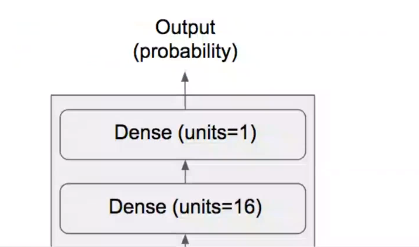

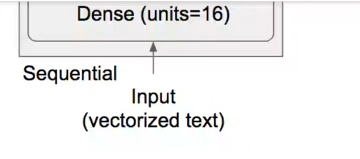

And here's the Keras implementation, very similar to the MNIST example you saw previously:


In [60]:
from tensorflow.keras import models
from tensorflow.keras import layers
model=models.Sequential()
model.add(layers. Dense (16, activation='relu', input_shape=(10000,)))
model.add(layers. Dense (16, activation='relu'))
model.add(layers. Dense (1, activation="sigmoid"))

In [61]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 16)                  │         160,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,305 (626.19 KB)

 Trainable params: 160,305 (626.19 KB)

 Non-trainable params: 0 (0.00 B)